In [56]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
from mpl_toolkits.axes_grid1 import make_axes_locatable
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq
import re

In [57]:
list_of_orders = pd.read_csv(r'C:\Users\ishaa\Documents\DataAnalysis\List of Orders.csv')
order_details = pd.read_csv(r'C:\Users\ishaa\Documents\DataAnalysis\Order Details.csv')
sales_target = pd.read_csv(r'C:\Users\ishaa\Documents\DataAnalysis\Sales target.csv')

In [58]:
list_of_orders.isna().sum()
order_details.isna().sum()
sales_target.isna().sum()

list_of_orders = list_of_orders.dropna()

In [59]:
type(sales_target['Month of Order Date'][0])
type(list_of_orders['Order Date'][0])

sales_target['Month of Order Date'] = pd.to_datetime(sales_target['Month of Order Date'], format = '%b-%y')
sales_target['Month of Order Date'] = pd.to_datetime(sales_target['Month of Order Date']).dt.to_period('M')
list_of_orders['Order Date'] = pd.to_datetime(list_of_orders['Order Date'])

In [60]:
temp = pd.merge(list_of_orders[['Order ID','Order Date']],
                  order_details[['Order ID','Amount','Category']],
                  on = 'Order ID')
temp['Month of Order Date'] = pd.to_datetime(temp['Order Date']).dt.to_period('M')
temp = temp.groupby(['Month of Order Date','Category']).sum().reset_index()

In [61]:
target = pd.merge(sales_target, temp, on = 'Month of Order Date')
target = target[target['Category_x'] == target['Category_y']].reset_index(drop=True)
target = target.drop(columns = 'Category_y')
target = target.rename(columns = {'Category_x':'Category'})
target['Month of Order Date'] = target['Month of Order Date'].astype(str)
target.head()

,Month of Order Date,Category,Target,Amount
0,2018-04,Furniture,10400.0,6570.0
1,2018-04,Clothing,12000.0,10743.0
2,2018-04,Electronics,9000.0,8857.0
3,2018-05,Furniture,10500.0,4677.0
4,2018-05,Clothing,12000.0,6986.0


In [62]:
target[target['Amount'] >= target['Target']]

,Month of Order Date,Category,Target,Amount
12,2018-08,Furniture,10900.0,15259.0
14,2018-08,Electronics,9000.0,16740.0
20,2018-10,Electronics,9000.0,15537.0
21,2018-11,Furniture,11300.0,12465.0
23,2018-11,Electronics,9000.0,10531.0
26,2018-12,Electronics,9000.0,11915.0
27,2019-01,Furniture,11500.0,15944.0
29,2019-01,Electronics,16000.0,22637.0


In [63]:
target['difference'] = target['Amount'] - target['Target']

furniture = target[target['Category'] == 'Furniture'].drop(columns = 'Category').set_index('Month of Order Date')
electronics = target[target['Category'] == 'Electronics'].drop(columns = 'Category').set_index('Month of Order Date')
clothing = target[target['Category'] == 'Clothing'].drop(columns = 'Category').set_index('Month of Order Date')
summation = target.groupby(['Month of Order Date']).sum()

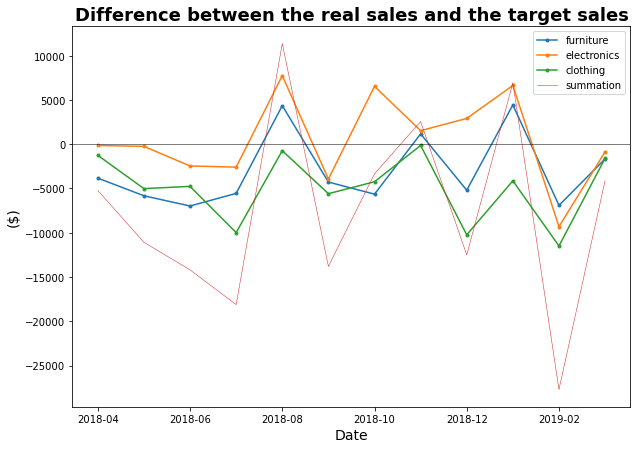

In [64]:
plt.figure(figsize = (10,7))

plt.plot(furniture['difference'], marker = '.', label = 'furniture')
plt.plot(electronics['difference'], marker = '.', label = 'electronics')
plt.plot(clothing['difference'], marker = '.', label = 'clothing')
plt.plot(summation['difference'],linewidth = .5, label = 'summation')
plt.legend()

plt.axhline(y = 0, color = 'black', linewidth = .5)
plt.xticks(summation.index[::2])
plt.xlabel('Date', fontsize = 14)
plt.ylabel('($)', fontsize = 14)
plt.title('Difference between the real sales and the target sales', fontdict={'fontweight':'bold', 'fontsize':18})

plt.show()


In [65]:
filename = 'Cities.csv'
headers = 'City,Latitude,Longitude\n'

f = open(filename, "w")
f.write(headers)

for j in range(1,9):    
    page_url = f'https://www.latlong.net/category/cities-102-15-{j}.html'

    uClient = uReq(page_url)
    page_soup = soup(uClient.read(), "html.parser")
    uClient.close()

    rows = page_soup.findAll('tr')
    rows = rows[1:]
    
    for row in rows:

        cell = row.findAll('td')

        City = cell[0].text
        Latitude = cell[1].text
        Longitude = cell[2].text

        f.write(City.replace(',', '|') + ',' + Latitude + ',' + Longitude + '\n')

f.close()

In [66]:
cities = pd.read_csv(r'C:\Users\ishaa\Documents\DataAnalysis\Cities.csv')
cities['Latitude'].astype(float)
cities['Longitude'].astype(float)
cities['City'] = cities['City'].str.split('|',expand=False).loc[:]
cities['City'] = cities['City'].str[0]

In [67]:
toiter = pd.DataFrame(list_of_orders['City'].unique())
for index, row in toiter[0].iteritems():
    if row in cities['City'].tolist():
        pass
    else:
        print(row)

Kashmir
Simla
Goa
Kohima
Allahabad


In [68]:
my_cities = pd.DataFrame(list_of_orders.groupby(['City']).count()['Order ID'])
city_map = my_cities.merge(cities[['City','Longitude','Latitude']], how='left', on='City')
city_map.set_index('City',inplace = True)

In [69]:
city_map.at['Allahabad','Latitude'] = 25.435113
city_map.at['Allahabad','Longitude'] = 81.845084
city_map.at['Goa','Latitude'] = 15.331737
city_map.at['Goa','Longitude'] = 74.126248
city_map.at['Kashmir','Latitude'] = 33.925603
city_map.at['Kashmir','Longitude'] = 76.137685
city_map.at['Kohima','Latitude'] = 25.674477
city_map.at['Kohima','Longitude'] = 94.108727
city_map.at['Simla','Latitude'] = 31.111610
city_map.at['Simla','Longitude'] = 77.169854

In [70]:
city_map = gpd.GeoDataFrame(city_map, 
                            geometry=gpd.points_from_xy(city_map.Longitude, city_map.Latitude))
city_map.drop(columns = ['Longitude', 'Latitude','Order ID'], inplace = True)
city_map.reset_index(inplace = True)

In [71]:
ind_dist = gpd.read_file(r'C:\Users\ishaa\Documents\DataAnalysis\IND_adm1.csv')
ind_dist = ind_dist[['NAME_1','geometry']]
ind_dist.rename(columns = {'NAME_1' : 'State'}, inplace = True)

DriverError: C:\Users\ishaa\Documents\DataAnalysis\IND_adm1.csv: No such file or directory

In [48]:
list_of_orders.replace('Kerala ','Kerala',inplace = True

SyntaxError: unexpected EOF while parsing (<ipython-input-48-0bd9d9d5a29b>, line 1)

In [32]:
orders = list_of_orders.groupby(['State']).count()['Order ID']
ind_dist = ind_dist.merge(orders, how = 'left', on='State')
ind_dist.rename(columns={'Order ID':'Orders'},inplace=True)
ind_dist['Orders'] = ind_dist['Orders'].fillna(0)

AttributeError: 'dict' object has no attribute 'plot'

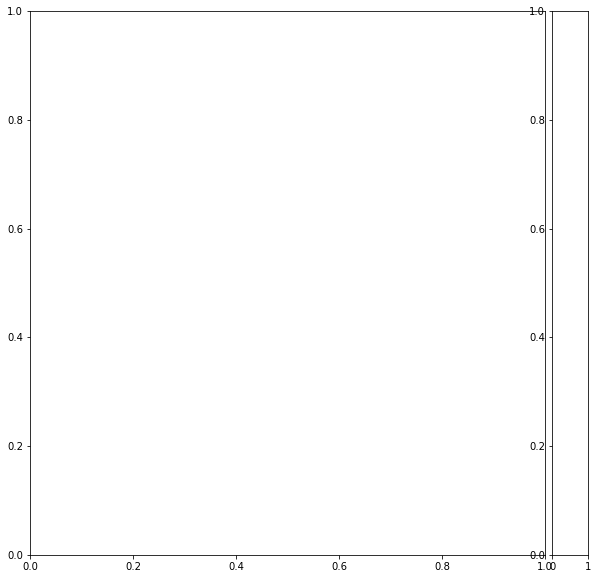

In [44]:
fig, ax = plt.subplots(figsize = (10,10))

divider = make_axes_locatable(ax)
cax = divider.append_axes(position = 'right', size = '7%', pad = 0.1)

ind_dist.plot(column = 'Orders', legend = True, cmap = 'Oranges_r', ax = ax, cax = cax,
             legend_kwds = {'label':'# of orders'}, alpha=0.8, edgecolor='k', linewidth=0.2)

city_map.plot(ax=ax, marker='o', color='r', markersize=45, edgecolor = 'k')

ax.set_title('# of orders by states in India', fontsize = 18)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()